<a href="https://colab.research.google.com/github/adedoyin-a/water-pollution-prediction/blob/Time-Series-Forecast-with-LSTM/LSTM_Water_Quality_Time_Series_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# load dataset

from google.colab import files
uploaded = files.upload()


Saving Beach_Water_Quality_-_Automated_Sensors_20250404.csv to Beach_Water_Quality_-_Automated_Sensors_20250404.csv


<ipython-input-2-916483f542a9>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0317 - mae: 0.1078 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0049 - mae: 0.0441 - val_loss: 7.4358e-04 - val_mae: 0.0204
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0048 - mae: 0.0436 - val_loss: 0.0014 - val_mae: 0.0323
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0048 - mae: 0.0439 - val_loss: 6.1860e-04 - val_mae: 0.0183
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0045 - mae: 0.0425 - val_loss: 6.0819e-04 - val_mae: 0.0182
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0051 - mae: 0.0450 - val_loss: 0.0015 - val_mae: 0.0330
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0051 - mae: 0.0456 - val_loss: 7.0093e-04 - val_mae: 0.0200
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0051 - mae: 0.0452 - val_loss: 6.5033e-04 - val_mae: 0.0194
Epoch 9/20
251/251 ━━━━━━━━━

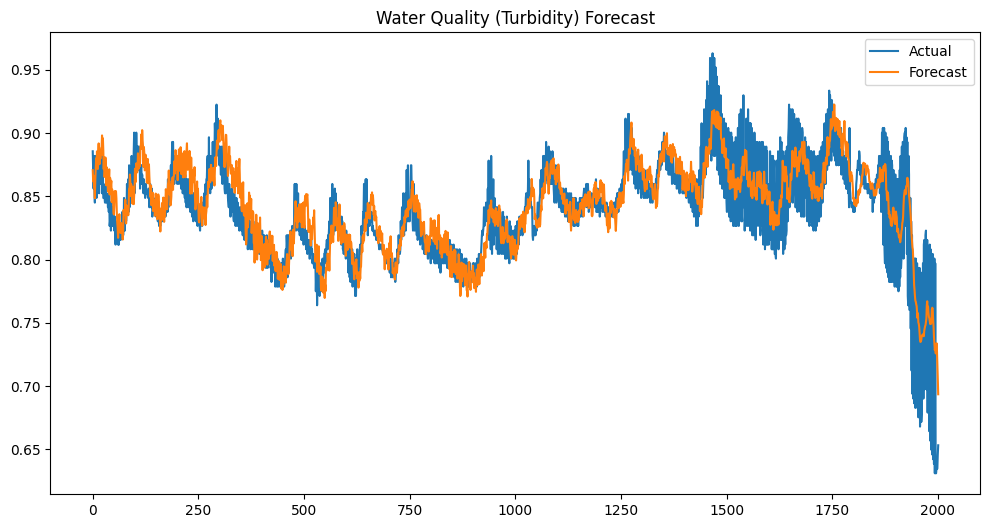

MAE: 0.018218454421094998
MSE: 0.0006081860390187715
RMSE: 0.024661428162593736
MAPE: 4.900063148327856
R² Score: 0.6141637577111967


,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period
Measurement Timestamp,,,,,
2013-08-30 08:00:00,20.3,1.18,0.891,0.080,3.0
2013-08-31 23:00:00,21.5,3.51,1.538,0.231,4.0
2013-09-03 03:00:00,21.9,4.97,1.039,0.241,7.0
2013-09-03 16:00:00,23.2,3.63,1.201,0.174,6.0
2013-09-18 10:00:00,18.9,7.56,1.517,0.140,4.0


In [2]:

df = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors_20250404.csv')
df.head()

# drop rows without turbidity

df = df.dropna()

# drop rows without turbidity

# df = df.dropna(subset=['Turbidity'])

# Remove invalid turbidity values
df = df[df['Turbidity'] >= 0]

# convert timestamp to date time

df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'])

#sort by date

df = df.sort_values('Measurement Timestamp')
df.set_index('Measurement Timestamp', inplace=True)

# drop columns not needed

df = df.drop(['Beach Name', 'Battery Life', 'Measurement Timestamp Label', 'Measurement ID'], axis=1, errors='ignore')

# forecast features and set turbidity as target

features = ['Water Temperature', 'Turbidity', 'Transducer Depth', 'Wave Height', 'Wave Period']
target = 'Turbidity'

# normalize dataset so all values fit into between 0 and 1

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# convert dataset into overlapping frequencies (last 24 hours) used to predict next value

def create_sequences(data, seq_length = 24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X, y = create_sequences(scaled, SEQ_LEN)

# Split dataset into train and test

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# build model

model = Sequential([LSTM(64, input_shape=(SEQ_LEN, len(features)), return_sequences=False), Dense(1)])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# train model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stop])

# predict and visualize forecast

forecast = model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Water Quality (Turbidity) Forecast')
plt.show()

# Inverse-transform predictions to get in real turbidity units

turbidity_scaler = MinMaxScaler()
turbidity_scaler.fit(df[['Turbidity']])

actual_turbidity = turbidity_scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_turbidity = turbidity_scaler.inverse_transform(forecast.reshape(-1, 1))

# evaluate model performance

mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R² Score: {r2}")

df.head()







